<center> <h1>Project Beta-Lactamase</h1> </center>
<center> <h4>Analysis and EDA</h4> </center>

In this part all the analysis and the feature engineering, all the parts and its corresponding reason of approach is been explained properly. Here the main aim is to get the feature engineered dataset and saving them for next set of analysis and model making. This contribution is based on the  [Call of Papers video](https://www.youtube.com/watch?v=_GtEgiWWyK4) by [Data Professor](https://www.youtube.com/channel/UCV8e2g4IWQqK71bbzGDEI4Q) sir. This notebook is the extension of the baseline notebook with some more analysis, as well as an approach to clean the data and getting the right csv data[train, test] for the underlined tasks, and also some future approaches coming up.

### Importing libraries and getting data

In [1]:
import os
import sys
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
path = os.path.join(os.getcwd()[:-5], 'Data/beta_lactamase_CHEMBL29.zip')
zf = zipfile.ZipFile(path, "r")

In [3]:
raw_data = pd.concat((pd.read_csv(zf.open(file)) for file in zf.namelist()))
data = raw_data.reset_index(drop=True)
print(f"shape of the data {data.shape}")

shape of the data (71973, 9)


In [4]:
data.head(3)

,molecule_chembl_id,canonical_smiles,standard_relation,standard_value,standard_units,standard_type,pchembl_value,target_pref_name,bao_label
0,CHEMBL1730,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=C(COC(C)...,=,10.0,/mM/s,Kcat/Km,NaN,Gil1,assay format
1,CHEMBL996,CO[C@@]1(NC(=O)Cc2cccs2)C(=O)N2C(C(=O)O)=C(COC...,NaN,NaN,NaN,Kcat/Km,NaN,Gil1,assay format
2,CHEMBL617,CC(=O)OCC1=C(C(=O)O)N2C(=O)[C@@H](NC(=O)Cc3ccc...,=,598.0,/mM/s,Kcat/Km,NaN,Gil1,assay format


As according the data `pchembl_value` is the value which is the value we have to predict as per the video, so in order to do that we 
have to remove the `NaN` values also what from this we also got one information that this is a `regression` based problem, but we can also frame this data for other kind of problem like classification, by taking `standard_type` into the consideration, then we can frame it as a `classification problem`
All of these could be solved using some standard families of GNN based approaches and architectures. So to summarize we can have :

1. `Regression` based task of predicting `pchembl_value` values from the set of molecules.
2. `Classification` based task of classifying `standard_type` from the set of molecules.
3. `Other tasks` which are Semi-supervised or `SSL / Generative` tasks could also be done.

But for now, as a baseline, our task is in ``Regression``

### Analysis Set 1

Here we will be checking the null values in the pchembl_value column, and see the distribution of the null vs not-null
values and remove the potentially null containing values

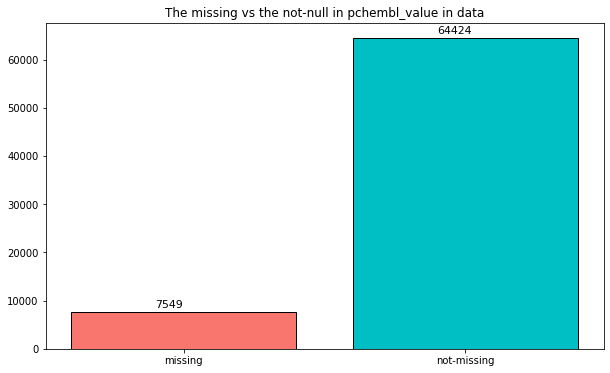

In [5]:
missing = data['pchembl_value'].isnull().sum()
not_missing = data['pchembl_value'].notnull().sum()


plt.figure(figsize=(10,6))
plt.title("The missing vs the not-null in pchembl_value in data")
x = ['missing', 'not-missing']
y = [missing, not_missing]
plt.bar(x = x, height = y, color = ['#F8766D', '#00BFC4'], ec = 'black')
for index, value in enumerate(y):
    plt.text(x = index-0.1, y = value + 1000, s = f"{value}", fontdict = dict(fontsize=11))
plt.show()

since only 10% if the data has `NULL` values so we can remove those values and then further analyse for the not-null values so we will be taking only those values of pchembl_value which are not null without thinking other some approaches, **BUT** we will also save the molecule entities which are having NULL values in an another dataframe so that we can use them as `TEST SET` and perform the task of interest (Supervised, Unsupervised/Semi-Supervised).

In [6]:
data_with_null = data[data['pchembl_value'].isnull()].reset_index(drop = True)

print(f"The shape of the data having null pchembl_value values is: {data_with_null.shape}")

The shape of the data having null pchembl_value values is: (7549, 9)


In [7]:
data_not_null = data[data['pchembl_value'].notnull()].reset_index(drop = True)

print(f"The shape of the data having no null pchembl_value values is : {data_not_null.shape}")

The shape of the data having no null pchembl_value values is : (64424, 9)


### Further Analysis 

Some of the description of the important columns as described from the video are as follows: 

1. `molecule_chembl_id` : The unique Id of the molecule 
2. `canonical_smiles`   : SMILEs structure of the molecules which can be converted to molecule objects using rd-kit
3. `standard_type`      : Label for the `classification` task
4. `pchembl_value`      : Label for the `regression` based task
5. `target_pref_name`   : Name of the protein
6. `bao_label`          : It says in what format the protein is being collected, whether it is in assay fromat or single protein format

**NOTE:**

Now, while building the model, we could separate the data based on the different target proteins and using those separated data (containing the filtered out different protein type) and building individual model out of them. Or we 
can build a single model for different target proteins under a single unified predictive model also called as ``proteochemometric model.`` So this could also be seen as a classification task.

**Analysis of Redundant entries of the molecules with different `pchembl_value` values**

So the idea is fairly simple here, we will keep those `molecule_chembl_id` values which are unique and do not contains any redundant values and for the `molecule_chembl_id`'s which are having redundant values and having different `pchembl_values` we will see whether their standard deviation is > 2 or not, if it is, then we will delete all those sets of the `molecule_chembl_id` else, we will merge them by averaging the `pchembl_values` of those redundant entries.

In [8]:
data_not_null[data_not_null['molecule_chembl_id'] == 'CHEMBL777'].head(3)

,molecule_chembl_id,canonical_smiles,standard_relation,standard_value,standard_units,standard_type,pchembl_value,target_pref_name,bao_label
0,CHEMBL777,O=C(O)[C@H]1/C(=C/CO)O[C@@H]2CC(=O)N21,=,9.0,nM,IC50,8.05,Gil1,assay format
2,CHEMBL777,O=C(O)[C@H]1/C(=C/CO)O[C@@H]2CC(=O)N21,=,70.0,nM,IC50,7.16,Beta-lactamase SCO-1,single protein format
26,CHEMBL777,O=C(O)[C@H]1/C(=C/CO)O[C@@H]2CC(=O)N21,=,25360.0,nM,Ki,4.60,Beta-lactamase SHV-5,single protein format


This is the table showing all those values having the same `molecule_chembl_id` as `CHEMBL777`, there are total of 37 such
entries, which had been truncated just to see the results. And all of these have different `pchembl_value` values.
So this is the reason why we have to take the collective data by merging them on the basis of the specified conditions 
above.

In [9]:
data_not_null.groupby('molecule_chembl_id').mean()

,standard_value,pchembl_value
molecule_chembl_id,,
CHEMBL1018,316.200000,6.500000
CHEMBL1024,11220.200000,4.950000
CHEMBL1028,2818.400000,5.550000
CHEMBL1036,39.800000,7.400000
CHEMBL104,27500.000000,4.580000
...,...,...
CHEMBL97643,11220.200000,4.950000
CHEMBL977,631.000000,6.200000
CHEMBL98406,63095.700000,4.200000


Here we are getting the mean `pchembl_value` values for the `molecule_chembl_id` values so, redundant values
like `CHEMBL777` will be takes as one by taking the mean of its `pchembl_value` but, all these will be taken into one consideration i.e. if only the `standard deviation` of all the `pchembl_values` for the very `molecule_chembl_id` must be < 2.

In [10]:
std_data = data_not_null.groupby('molecule_chembl_id').std()
std_data[std_data['pchembl_value'].notnull()]

,standard_value,pchembl_value
molecule_chembl_id,,
CHEMBL104,10606.601718,0.169706
CHEMBL1089781,2418.627366,0.459891
CHEMBL1091,39575.140197,0.212132
CHEMBL109227,0.000000,0.000000
CHEMBL1126,2545.584412,0.212132
...,...,...
CHEMBL87686,6984.086607,1.866762
CHEMBL87719,339.411255,0.869741
CHEMBL891,7496.901315,1.836146


So these are the `molecule_chembl_id` which are having redundant values and now what we have to do is that we have to
filter out those `ids` whole SD of `pchembl_value` is > 2 such that we can drop those at once.

**PART 1: Dropping the ids whose `pchembl_value` > 2**

In [11]:
std_data_not_null = std_data[std_data['pchembl_value'].notnull()]
ids_to_remove = std_data_not_null[std_data_not_null['pchembl_value'] > 2]

print("These are the id we have to remove from the dataframe\n")
ids_to_remove

These are the id we have to remove from the dataframe



,standard_value,pchembl_value
molecule_chembl_id,,
CHEMBL166730,64389.850602,2.382950
CHEMBL1795572,17890.931511,2.041429
CHEMBL3234727,50133.870786,2.015254
CHEMBL338933,45711.707563,2.020726
CHEMBL4114669,15575.928775,2.232136
CHEMBL4114749,2605.293120,2.141316
CHEMBL4533632,3604.123264,2.283955
CHEMBL67925,7068.239385,2.404163


In [12]:
ids_removing = ['CHEMBL166730','CHEMBL1795572', 'CHEMBL3234727', 'CHEMBL338933', 
                'CHEMBL4114669', 'CHEMBL4114749','CHEMBL4533632','CHEMBL67925',]

index_of_ids_to_remove = []

for ids in ids_removing:
    index_of_ids_to_remove.extend(list(data_not_null.index[data_not_null['molecule_chembl_id'] == ids].values))

We got all the indices in the dataframe which are having the id values present in the list of `ids_removing`
and so now, we will just drop those indices, and we get the filtered out values

In [13]:
data_not_null = data_not_null.drop(labels = index_of_ids_to_remove, axis = 0)

In [14]:
print(f"After removing the redundant of SD > 2 shape becomes: {data_not_null.shape}")

After removing the redundant of SD > 2 shape becomes: (64404, 9)


**PART 2: Merging the ids all having redundant ids and different `pchembl_values`**

In [15]:
merged = data_not_null.groupby(['molecule_chembl_id']).mean().reset_index()

print(f"After drops and merge based on criterions above the shape of data is: {merged.shape}")

After drops and merge based on criterions above the shape of data is: (63030, 3)


In [16]:
merged_with_data = merged.merge(
                    data_not_null, 
                    on = ["molecule_chembl_id", "molecule_chembl_id", "standard_value"]).reset_index(drop = True)

In [17]:
merged_with_data['molecule_chembl_id'].value_counts()

CHEMBL1484       3
CHEMBL20852      2
CHEMBL1375425    2
CHEMBL139928     2
CHEMBL113381     2
                ..
CHEMBL1571404    1
CHEMBL1391890    1
CHEMBL1449107    1
CHEMBL1976225    1
CHEMBL1483475    1
Name: molecule_chembl_id, Length: 62252, dtype: int64

From this we can see, that somehow some of the data got duplicated, and now we have to check whether those duplicated
values have different `pchembl_value_y` or not. And I have explored this part just by seeing those duplicated rows 
in the dataframe format by doing this : **`merged_with_data[merged_with_data.duplicated()]`** and compared the `pchembl_value_y` with each of the duplicated values, and those where all same, which means those are simply duplicated values, and so we just remove in the conventional way.

In [18]:
indices_to_delete = list(merged_with_data[merged_with_data.duplicated()].index)
indices_to_delete.append(58616) # for some reason, have to explicitely append this index

merged_data = merged_with_data.drop(labels = indices_to_delete, axis = 0)

In [19]:
# checking NaN values in the merged_data

merged_data.isnull().sum()

molecule_chembl_id     0
standard_value         0
pchembl_value_x        0
canonical_smiles      16
standard_relation      0
standard_units         0
standard_type          0
pchembl_value_y        0
target_pref_name       0
bao_label              0
dtype: int64

Still 16 `canonical_smiles` have NaN values, so we have to remove those.

In [20]:
merged_data = merged_data.dropna()

In [21]:
# droping the excess pchembl_value_x value from the dataframe and renaming pchembl_value_y as pchembl_value

merged_data = merged_data.drop(['pchembl_value_x'], axis = 1)
merged_data = merged_data.rename(columns = {'pchembl_value_y' : 'pchembl_value'})

In [22]:
print(f"Finally our shape of the dataframe is : {merged_data.shape}")

Finally our shape of the dataframe is : (62236, 9)


So after all these operations, still our data has > `60K` data points which is very good for training. Now this dataframe has :

1. No redundant Ids
2. No NaN values
3. No redundant Ids having std of `pchembl_values` > 2

So this means now our data is good to go for consideration of the next steps of Feature Engineering.
we will be exploring the `pchembl_values` and some other columns into more details.


### Analysis Set 2

Here we will be analysing the dataframe free from all sorts of NaN values in some more details and future approaches that can be applied to get a solution.

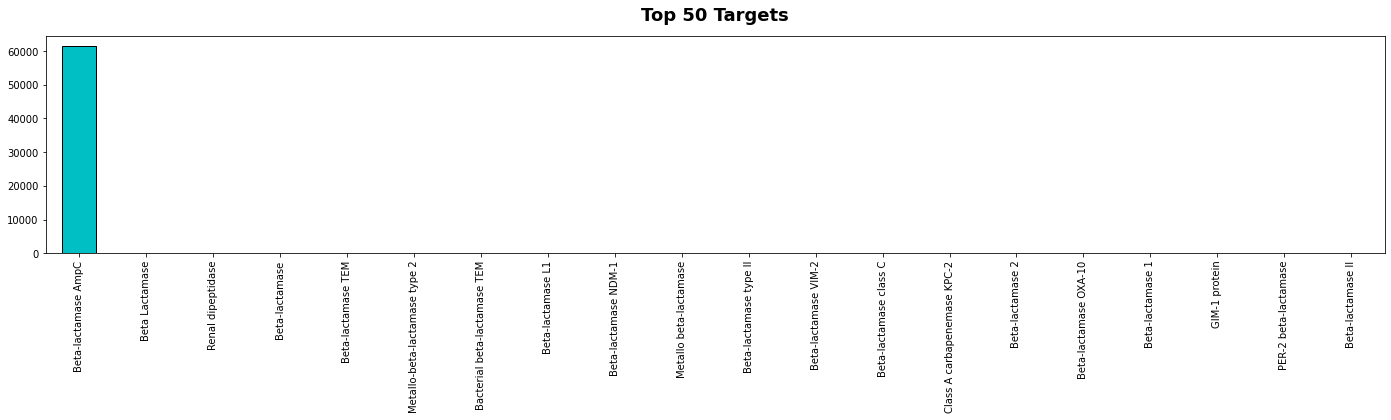

In [23]:
# Top 10 Target protein names.

plt.figure(figsize=(10, 6))
merged_data.target_pref_name.value_counts()[0:50].plot.bar(figsize=(24,4), color='#00BFC4', ec='black')

plt.title('Top 50 Targets', fontsize=18, fontweight='black', pad=15)
plt.show()

This shows that the column `target_pref_name` is also very much to handle, so what we can do is either filter out the 
ones with most values, or we can keep those. As if we do the regression tasks, with the SMILES only in that case
those are not required much.

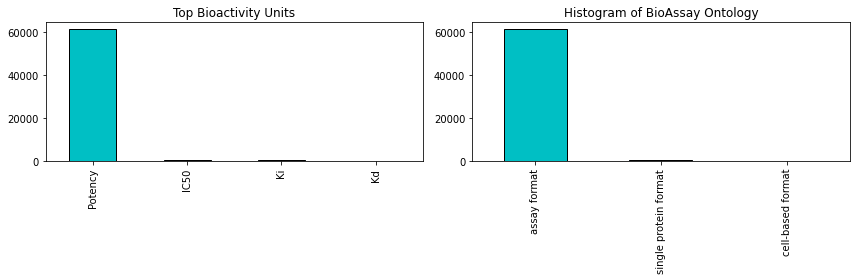

In [24]:
# Top Bioactivity and BAO labels counts

figure, axes = plt.subplots(1, 2)
merged_data.standard_type.value_counts()[:10].plot.bar(
    figsize=(12,4), color='#00BFC4', ec='black', ax = axes[0], title = "Top Bioactivity Units")


bao_labels = merged_data.bao_label.value_counts()
bao_labels.plot.bar(
    figsize=(12,4), color='#00BFC4', ec='black', ax = axes[1], title = "Histogram of BioAssay Ontology")

figure.tight_layout()
plt.show()

Similarly the `Bioactivity units` and `BAO` dist are also very much unstable. Though based on the task here, which is regression if we are not implementing a **`Hybrid Model (GNN + simple ANN)`** it must not be much a problem. Now lets analyse the distribution of **`pchembl_values`**

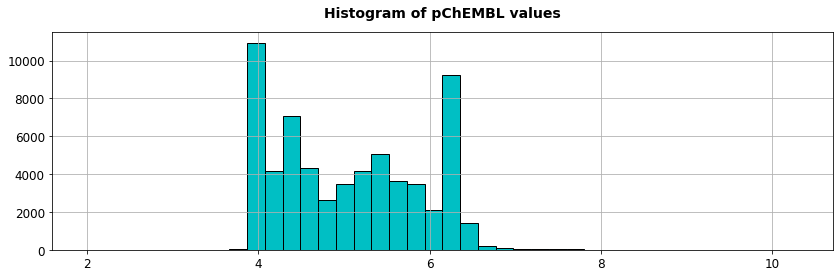

In [25]:
# plot the distribution of the data

merged_data.pchembl_value.hist(bins=40, figsize=(14,4), color='#00BFC4', ec='black')

plt.title('Histogram of pChEMBL values', fontsize=14, fontweight='black', pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

From this graph what we can see that most of the values lies in range of `4 to 6`, but most of the values lies 
in the values of ranges from `3.8 < x < 4.5` and `6.5 < x < 7.2` approximately. As this also shows that the values in `pchembl_value` are highly unstable as
most of the `pchembl_value` values are having value of **6.20** or in that range and also most of the values are : `[6.20, 4.00, 4.05, 3.95, 4.35]`, Which means that the intial data is very much unstable but we can some how solve this problem using **Graph Augmentations** approaches.

The approach is somewhat like this:
```
SMILES --➡ Rd-Kit Object --➡ PyG-graph --➡ GraphAugmentations Techniques
                                                          |
                                                          |
                                                          ⬇
                                               [G1, G2 ......... , Gn]
                                            ----- Aug graph generated ----
             Genarted new smiles data                     |
                     ⬆                                    |
                     |                                    |
                     |                                    ⬇
                     |                                     
           [SMILE1, SMILE2 .... SMILEn] ⬅-----------  Rd-Kit Object    
```

The main gain in this approach is that though we will be having redundant rows but the `SMILES` structure would be
completely different geometrically but will be same w.r.t its properties and attributes.

Now this could be done, once all the feature engineering techniques are done, also I am taking here Rd-Kit instead of using PaDelPy because it works seamlessly with PyG and kinda easy to use. Now we will try to implement this approach in the next analysis so that the distribution of the dataset gets stabilized.

In [26]:
# saving the train and the test set of the data

merged_data.to_csv('train_data.csv')
data_with_null.to_csv('test_data.csv')